# Daily Motivation Quotes


## Business Understanding

In a world filled with daily challenges and responsibilities, staying motivated is essential for personal growth and well-being. This data science project is dedicated to curating and delivering a diverse collection of carefully selected quotes. These inspirational snippets, sourced from various outlets including historical figures, popular literature, and notable personalities, aim to provide a source of encouragement, reflection, and empowerment for individuals facing the hustle of everyday life.

#### Objectives:

The primary objectives of this project are as follows:
1.	Curate Inspirational Quotes:
Gather a diverse collection of quotes from the Good Reads website, which boasts an extensive compilation of quotes spanning various genres and themes.
2.	Daily Motivational Updates: Develop a system to provide users with daily updates featuring a thoughtfully chosen quote. These updates will cater to different areas of life, ensuring a comprehensive and relatable experience.
3.	Tag-based Grouping: Implement a categorization mechanism that tags each quote based on its thematic content. This grouping will enable users to easily identify quotes that resonate with their specific preferences or current situations.


## Data Understanding

•	Source quotes from the Good Reads website, exploring the wide array of authors and themes available.

•	Analyze the structure of the collected data, including metadata such as author names, publication dates, and associated tags.


In [1]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import scrapy 
import zipfile

import string
#from pathlib import path

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk import FreqDist
import plotly.express as px

from langdetect import detect
from googletrans import Translator

from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from textblob import TextBlob



from my_functions import translate_to_english, preprocess_text, preprocesss_text, compress_tags, clean_text

### 3.	Data Preparation
After obtaining the data we intend to use, we wil now open it here and begin the data cleaning process before proceeding to analysis.

In [2]:
# Reading the data
quotes = pd.read_csv(r'data/Quotes.csv', index_col=0)

# Read new dataset. 
"""We will reaad it directly from the Zipfile"""
with zipfile.ZipFile('data/tweets data.zip', 'r') as zip_ref:
    zip_ref.extractall('data')
    
#Read the data into a data frame
tweets = pd.read_csv(r'data/Tweets.csv')


In [3]:
quotes

,Author Name,Quote,Tags
0,Oscar Wilde,“Be yourself; everyone else is already taken.”...,"['attributed-no-source', 'be-yourself', 'gilbe..."
1,Marilyn Monroe,"“I'm selfish, impatient and a little insecure....","['attributed-no-source', 'best', 'life', 'love..."
2,Albert Einstein,“Two things are infinite: the universe and hum...,"['attributed-no-source', 'human-nature', 'humo..."
3,Frank Zappa,"“So many books, so little time.” ― F...","['books', 'humor']"
4,Marcus Tullius Cicero,“A room without books is like a body without a...,"['attributed-no-source', 'books', 'simile', 's..."
...,...,...,...
2995,"A.A. Milne,",“I'm not lost for I know where I am. But howev...,NaN
2996,Henry David Thoreau,“Dreams are the touchstones of our characters....,NaN
2997,"Cassandra Clare,",“Black hair and blue eyes are my favorite comb...,NaN
2998,"Nicholas Sparks,",“In times of grief and sorrow I will hold you ...,NaN


We observe that the tags column did not get all the tags for the quotes and we will need to fill them up or remove them if that will not be possible. 
Although removing them will really affect the number of quotes availabe for us to use, therefore removing them will be a last resort. 
We will attempt to fill them based on the author. 

In [4]:
# Checking actual number of missing values. 
quotes.isna().sum()

Author Name      0
Quote            0
Tags           502
dtype: int64

In [5]:
# checking contents of the quote column. 
quotes['Quote'][3]

'“So many books, so little time.”      ―      Frank Zappa'

It appears the quote column still kept the name of the author. We can redo the split again below. We also observe that the quotes have extra quotes that will remain after separating the name from the quote, that will need to be removed as well to only leave a single double quotation mark. 

In [6]:
#  Split the content after the hyphen (―) into 'quote' and 'author' columns
quotes[['quote', 'author']] = quotes['Quote'].str.split('―',  expand=True)

# Strip leading and trailing whitespaces from 'quote' and 'author' columns
quotes['quote'] = quotes['quote'].str.strip()
quotes['author'] = quotes['author'].str.strip()

# Drop the original 'Quote' column since we have extracted its contents
quotes.drop('Quote', axis=1, inplace=True)

In [7]:
nan = quotes[quotes['Tags'].isna()]

In [8]:
nan

,Author Name,Tags,quote,author
2498,"John Green,",NaN,“And then something invisible snapped insider ...,"John Green, Looking for Alaska"
2499,Aristotle,NaN,“Hope is a waking dream.”,Aristotle
2500,Annie Proulx,NaN,“You should write because you love the shape o...,Annie Proulx
2501,Bill Watterson,NaN,“I'm killing time while I wait for life to sho...,Bill Watterson
2502,Alex Haley,NaN,"“Either you deal with what is the reality, or ...",Alex Haley
...,...,...,...,...
2995,"A.A. Milne,",NaN,“I'm not lost for I know where I am. But howev...,"A.A. Milne, Winnie-the-Pooh"
2996,Henry David Thoreau,NaN,“Dreams are the touchstones of our characters.”,Henry David Thoreau
2997,"Cassandra Clare,",NaN,“Black hair and blue eyes are my favorite comb...,"Cassandra Clare, Clockwork Angel"
2998,"Nicholas Sparks,",NaN,“In times of grief and sorrow I will hold you ...,"Nicholas Sparks, The Notebook"


In [9]:
# preview the changes
quotes['quote'][53]

"“If you don't stand for something you will fall for anything.”"

In [10]:
quotes.groupby('Author Name').sum()

,Tags,quote,author
Author Name,,,
"A. A. Milne,",['antolini'],“It is more fun to talk with someone who doesn...,"A. A. Milne, Winnie-the-Pooh"
A.A. Milne,"['happiness', 'hope', 'inspirational', 'new-ye...","“Weeds are flowers, too, once you get to know ...",A.A. MilneA.A. MilneA.A. MilneA.A. MilneA.A. M...
"A.A. Milne,",['live-death-love']['activism']['dave-matthews...,"“Piglet sidled up to Pooh from behind. ""Pooh!""...","A.A. Milne, The House at Pooh CornerA.A. Miln..."
A.J. Cronin,['writing'],"“Worry never robs tomorrow of its sorrow, but ...",A.J. Cronin
Abigail Van Buren,['life'],“The best index to a person's character is how...,Abigail Van Buren
...,...,...,...
جلال الدين الرومي,0,“لا تجزع من جرحك، وإلا فكيف للنور أن يتسلل إلى...,جلال الدين الرومي
عباس محمود العقاد,0,“ليس هناك كتابا أقرأه و لا أستفيد منه شيئا جدي...,عباس محمود العقاد
غسان كنفاني,['identity'],“!لك شيء في هذا العالم.. فقم”,غسان كنفاني


Checking the distribution of the authors and their quotes, we realize that some of them are not actually in english and this would affect the outcome of our code when filling the nan tags. we therefore need to translate them to English before preprocessing them for the fill. 
we can do that using the langdetect package available  in python together with googletrans package. 
we will install them using Pip then restart kernel and import them with the other packages.

Next, we will write a function that will do the translation for us called translate to english that is available in out my functions file. 

In [11]:
# Apply the translation function from my function file to the quote column
#quotes['quote_2'] = quotes['quote'].apply(translate_to_english)


Below we will also apply the translate to english function on the author column to have the names in English. the following codes really took a long time running on my local machine, therefore, I opted to run them using cloud services, i.e. google colab then saved the new dataframe to a new file that we will read below. 

In [12]:
# Apply the translation function from my function file to the author column
# quotes['author_2'] = quotes['Author Name'].apply(translate_to_english)


In [13]:
quotes.groupby('Author Name').sum()

,Tags,quote,author
Author Name,,,
"A. A. Milne,",['antolini'],“It is more fun to talk with someone who doesn...,"A. A. Milne, Winnie-the-Pooh"
A.A. Milne,"['happiness', 'hope', 'inspirational', 'new-ye...","“Weeds are flowers, too, once you get to know ...",A.A. MilneA.A. MilneA.A. MilneA.A. MilneA.A. M...
"A.A. Milne,",['live-death-love']['activism']['dave-matthews...,"“Piglet sidled up to Pooh from behind. ""Pooh!""...","A.A. Milne, The House at Pooh CornerA.A. Miln..."
A.J. Cronin,['writing'],"“Worry never robs tomorrow of its sorrow, but ...",A.J. Cronin
Abigail Van Buren,['life'],“The best index to a person's character is how...,Abigail Van Buren
...,...,...,...
جلال الدين الرومي,0,“لا تجزع من جرحك، وإلا فكيف للنور أن يتسلل إلى...,جلال الدين الرومي
عباس محمود العقاد,0,“ليس هناك كتابا أقرأه و لا أستفيد منه شيئا جدي...,عباس محمود العقاد
غسان كنفاني,['identity'],“!لك شيء في هذا العالم.. فقم”,غسان كنفاني


In [14]:
# Reading the new file 
quotes_2 = pd.read_csv(r'data\quotes_2.csv', index_col=0)
quotes_2

,Author Name,Tags,quote,author,quote_2,author_2
0,Oscar Wilde,"['attributed-no-source', 'be-yourself', 'gilbe...",“Be yourself; everyone else is already taken.”,Oscar Wilde,“Be yourself;Everyone else is already taken. ”,Oscar Wilde
1,Marilyn Monroe,"['attributed-no-source', 'best', 'life', 'love...","“I'm selfish, impatient and a little insecure....",Marilyn Monroe,"“I'm selfish, impatient and a little insecure....",Marilyn Monroe
2,Albert Einstein,"['attributed-no-source', 'human-nature', 'humo...",“Two things are infinite: the universe and hum...,Albert Einstein,“Two things are infinite: the universe and hum...,Albert Einstein
3,Frank Zappa,"['books', 'humor']","“So many books, so little time.”",Frank Zappa,"“So many books, so little time.”",Frank Zappa
4,Marcus Tullius Cicero,"['attributed-no-source', 'books', 'simile', 's...",“A room without books is like a body without a...,Marcus Tullius Cicero,“A room without books is like a body without a...,Marcus Tullius cicero
...,...,...,...,...,...,...
2995,"A.A. Milne,",NaN,“I'm not lost for I know where I am. But howev...,"A.A. Milne, Winnie-the-Pooh",“I'm not lost for I know where I am. But howev...,"A.A.Milne,"
2996,Henry David Thoreau,NaN,“Dreams are the touchstones of our characters.”,Henry David Thoreau,“Dreams are the touchstones of our characters.”,Henry David Thoreau
2997,"Cassandra Clare,",NaN,“Black hair and blue eyes are my favorite comb...,"Cassandra Clare, Clockwork Angel",“Black hair and blue eyes are my favorite comb...,"Cassandra Clare,"
2998,"Nicholas Sparks,",NaN,“In times of grief and sorrow I will hold you ...,"Nicholas Sparks, The Notebook",“In times of grief and sorrow I will hold you ...,"Nicholas Sparks,"


Below we will perfomt some Data wrangling techniques to ensure we have comprehensive data to work with. 

In [15]:
# Drop duplicate rows across all columns
quotes_2 = quotes_2.drop_duplicates()

In [16]:
# Replace missing values with the most common value of each column in: 'Tags'
quotes_2 = quotes_2.fillna({'Tags': quotes_2['Tags'].mode()[0]})

In [17]:
quotes_2.groupby('Author Name').sum()

,Tags,quote,author,quote_2,author_2
Author Name,,,,,
"A. A. Milne,",['antolini'],“It is more fun to talk with someone who doesn...,"A. A. Milne, Winnie-the-Pooh",“It is more fun to talk with someone who doesn...,"A. A. Milne,"
A.A. Milne,"['happiness', 'hope', 'inspirational', 'new-ye...","“Weeds are flowers, too, once you get to know ...",A.A. MilneA.A. MilneA.A. MilneA.A. MilneA.A. M...,"“Weeds are flowers, too, once you get to know ...",A.A.MilneA.A.MilneA.A.MilneA.A.MilneA.A.MilneA...
"A.A. Milne,",['live-death-love']['activism']['dave-matthews...,"“Piglet sidled up to Pooh from behind. ""Pooh!""...","A.A. Milne, The House at Pooh CornerA.A. Miln...","“Piglet sidled up to Pooh from behind. ""Pooh!""...","A.A.Milne,A.A.Milne,A.A.Milne,A.A.Milne,A.A.Mi..."
A.J. Cronin,['writing'],"“Worry never robs tomorrow of its sorrow, but ...",A.J. Cronin,"“Worry never robs tomorrow of its sorrow, but ...",A.J. Cronin
Abigail Van Buren,['life'],“The best index to a person's character is how...,Abigail Van Buren,“The best index to a person's character is how...,Abigail Van Buren
...,...,...,...,...,...
جلال الدين الرومي,['love'],“لا تجزع من جرحك، وإلا فكيف للنور أن يتسلل إلى...,جلال الدين الرومي,"""Do not be alarmed by your wound, otherwise, h...",Jalal al -Din al -Roumi
عباس محمود العقاد,['love'],“ليس هناك كتابا أقرأه و لا أستفيد منه شيئا جدي...,عباس محمود العقاد,“There is no book I read and do not benefit fr...,Abbas Mahmoud Al -Akkad
غسان كنفاني,['identity'],“!لك شيء في هذا العالم.. فقم”,غسان كنفاني,“You have something in this world .. So”,Ghassan kanfani


### Visualizations

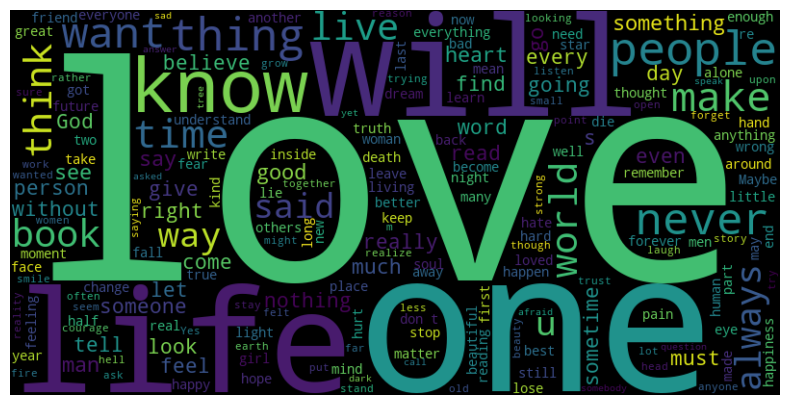

In [18]:
# Word Cloud for the words that appear most in quotes
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(' '.join(quotes_2['quote_2']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

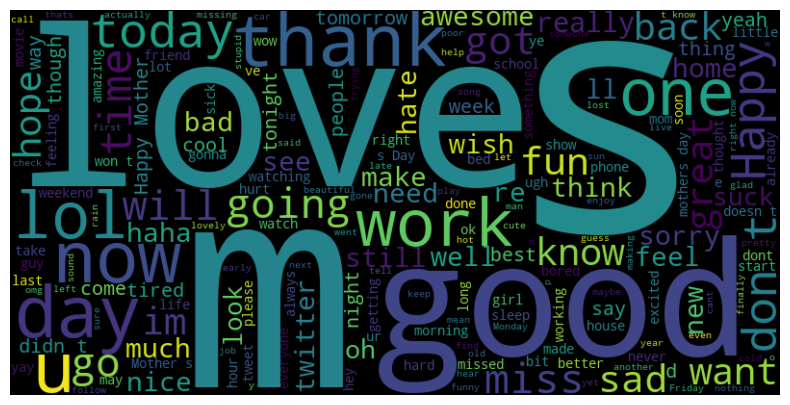

In [19]:
# Word Cloud for the words that appear most in tweets
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(' '.join(tweets['selected_text'].astype(str)))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


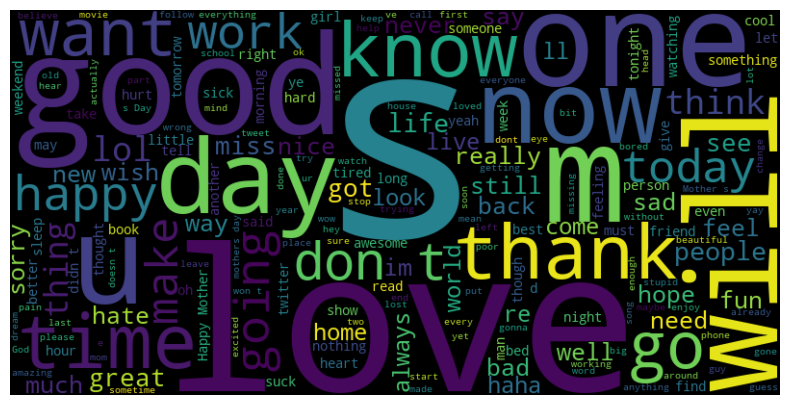

In [20]:
# Combine text from 'selected_text' and 'quote_2'
combined_text = ' '.join(tweets['selected_text'].astype(str)) + ' ' + ' '.join(quotes_2['quote_2'])

# Word Cloud for the words that appear most in both tweets and quotes
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(combined_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


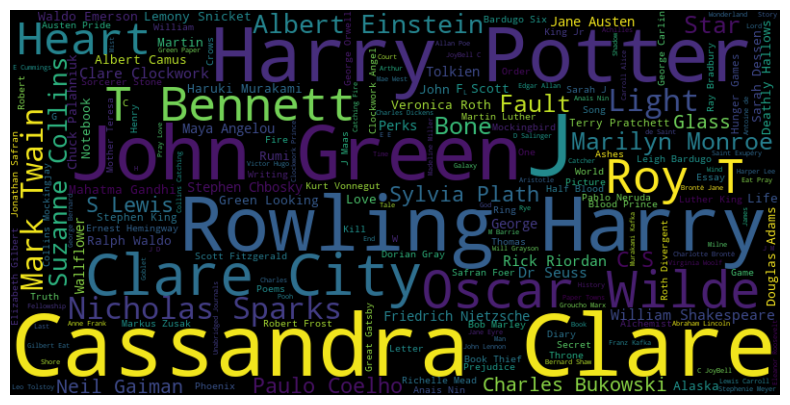

In [21]:
# Word Cloud for the author names that appear the most
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(' '.join(quotes_2['author']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

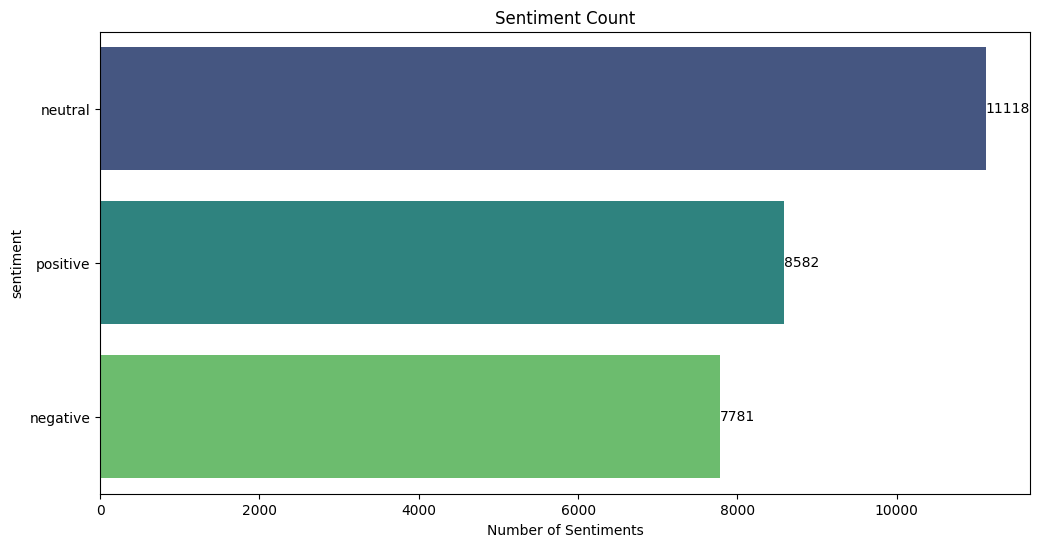

In [22]:
# Sentiment Count Bar Plot
sentiment_count = tweets['sentiment'].value_counts()
plt.figure(figsize=(12, 6))
sns.barplot(x=sentiment_count.values, y=sentiment_count.index, hue=sentiment_count.index, palette='viridis', dodge=False, legend=False)
plt.title('Sentiment Count')
plt.xlabel('Number of Sentiments')

# Adding count labels for each bar
for index, value in enumerate(sentiment_count.values):
    plt.text(value, index, str(value), ha='left', va='center', fontsize=10)

plt.show()


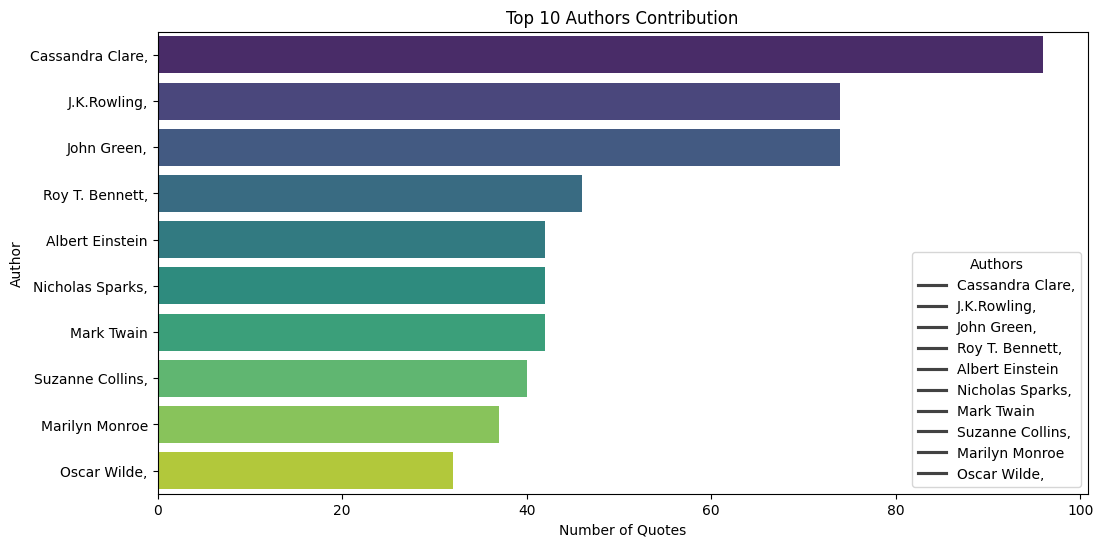

In [23]:
# Author Contribution Bar Chart
author_counts = quotes_2['author_2'].value_counts().head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=author_counts.values, y=author_counts.index, hue=author_counts.index, palette='viridis', dodge=False)
plt.title('Top 10 Authors Contribution')
plt.xlabel('Number of Quotes')
plt.ylabel('Author')
plt.legend(title='Authors', loc='lower right', labels=author_counts.index)
plt.show()


In [25]:
# Assuming quotes_2 is your DataFrame and 'Tags' is the column containing lists of tags as strings
quotes_2['Tags'] = quotes_2['Tags'].apply(eval)  # Convert string representation to actual list

quotes_2['Compressed_Tags'] = quotes_2['Tags'].apply(compress_tags)

# Display the resulting DataFrame
print(quotes_2[['Tags', 'Compressed_Tags']])


                                                   Tags  \
0     [attributed-no-source, be-yourself, gilbert-pe...   
1     [attributed-no-source, best, life, love, misat...   
2     [attributed-no-source, human-nature, humor, in...   
3                                        [books, humor]   
4           [attributed-no-source, books, simile, soul]   
...                                                 ...   
2995                                             [love]   
2996                                             [love]   
2997                                             [love]   
2998                                             [love]   
2999                                             [love]   

                                        Compressed_Tags  
0     [honesty, be-yourself, inspirational, attribut...  
1     [worst, love, best, misattributed-marilyn-monr...  
2     [humor, science, stupidity, human-nature, attr...  
3                                        [books, humor]  
4

In [27]:
# Assuming 'Compressed_Tags' is the column containing lists of tags

quotes_2['Tags_'] = quotes_2['Compressed_Tags'].apply(tuple)  # Convert lists to tuples


# Tag Distribution Pie Chart
tag_counts = quotes_2.groupby(by='Tags_').size().nlargest(10).reset_index(name='Count')
fig = px.pie(tag_counts, names='Tags_', values='Count', title='Tags Distribution', 
             custom_data=['Tags_'])  # Add 'Tags_' to custom_data

# Update layout to display custom data on hover
fig.update_traces(hovertemplate='Tag: %{customdata[0]}<br>Count: %{value}')

fig.show()


We observe that the love tag has the highest number of quotes, but upon further investigation of the data, i fund out that the fill we used for the nan present in the column mostly filled them with Love some of which were wrongly filles since the quote was not  about love.<br>
We will continue with the visualizations now to further investigate the Tags column to see if there are any other anomalies present. 

In [28]:
tag_counts = quotes_2.groupby(by='Tags_').sum().tail(20)

fig = px.pie(tag_counts, names=tag_counts.index, title='Tag Distribution')

fig.update_traces(textfont_size=12, textinfo='percent + label') # increase the text size

fig.update_traces(marker=dict(colors=[ 'magenta' , 'yellow' , 'grey' , 'green' , 'purple' , 'slategrey' , 'blue' , 'black' ])) # update the pie chart colors

fig.show()

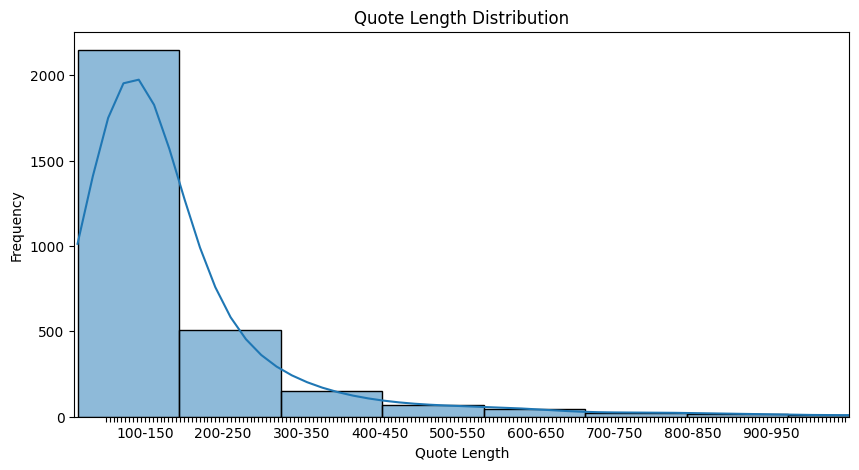

In [29]:
# Quote Length Distribution
quote_lengths = quotes_2['quote'].apply(len)
plt.figure(figsize=(10, 5))
sns.histplot(quote_lengths, bins=30, kde=True)
plt.title('Quote Length Distribution')
plt.xlabel('Quote Length')
plt.ylabel('Frequency')
plt.xlim([10, 1000])
xticks = np.arange(50, 1000, 5)

# Create custom labels based on your requirements
custom_labels = [f'{i}-{i + 50}' if i % 100 == 0 else '' for i in xticks]

plt.xticks(xticks, labels=custom_labels)


plt.show()

### EDA

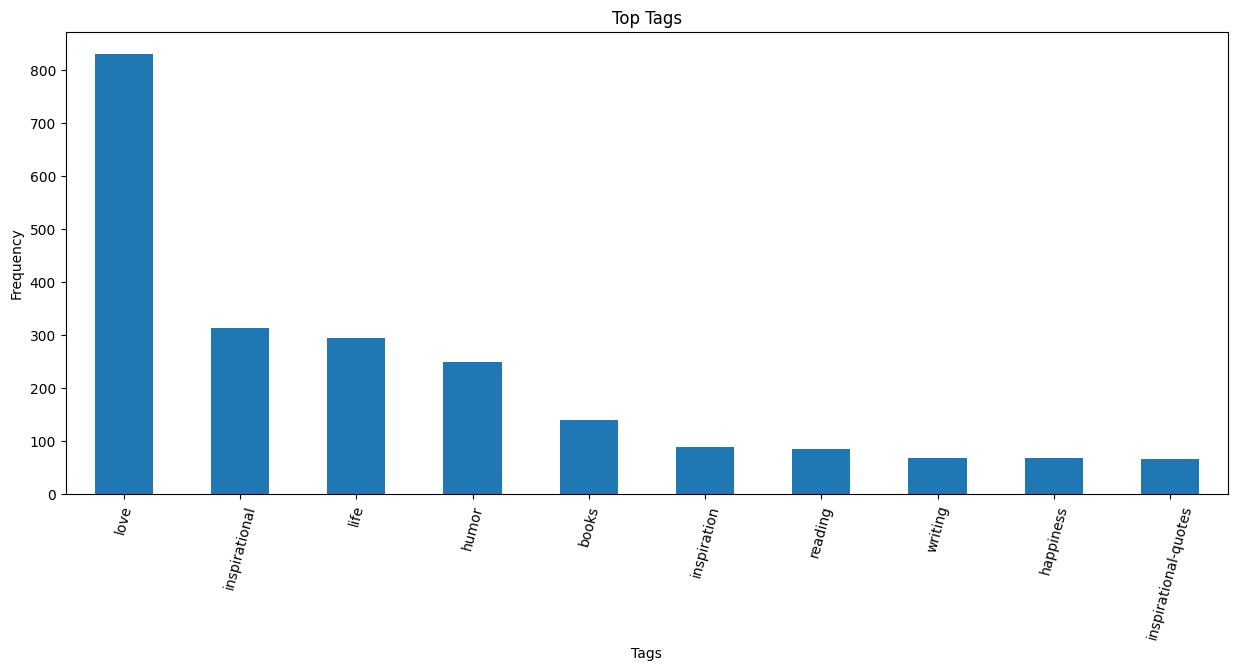

In [30]:
# Extract the 'Tags' column
Tags = quotes_2['Tags']

# Flatten the list of Tags
flat_Tags = [tag for sublist in Tags for tag in sublist]

# Count the frequency of each keyword
keyword_counts = pd.Series(flat_Tags).value_counts().head(10)

# Select the top Tags
top_Tags = keyword_counts.head(20) 

# Plot the top Tags
plt.figure(figsize=(15, 6))
top_Tags.plot(kind='bar')
plt.title('Top Tags')
plt.xlabel('Tags')
plt.ylabel('Frequency')
plt.xticks(rotation=75)
# save the figure
#plt.savefig(".data/images/Tags_plot")
plt.show()

In [33]:
tweets['token_text'] = tweets['selected_text'].apply(preprocesss_text)
tweets['token_text']

Top selected_text:
good     1253
day      1074
love      911
happy     854
like      774
get       774
go        704
got       659
work      624
going     594
Name: count, dtype: int64


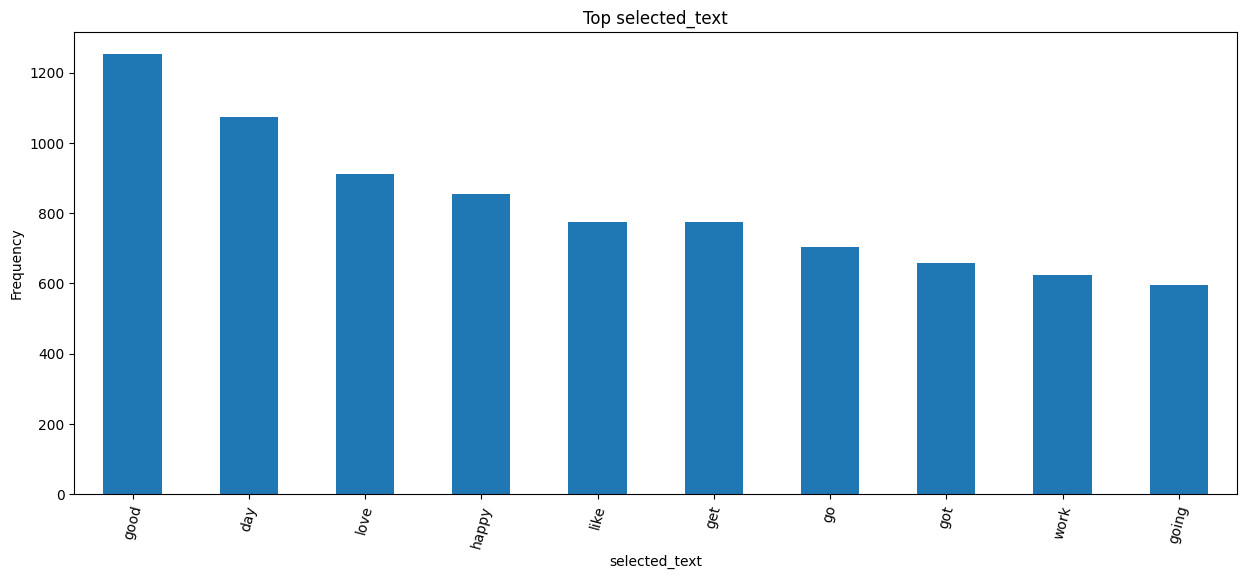

In [35]:
# Extract the 'selected_text' column
selected_text = tweets['token_text']

# Filter out any non-string values
selected_text = selected_text.loc[selected_text.apply(lambda x: isinstance(x, str))]

# Replace any non-alphanumeric characters with a space
selected_text = selected_text.str.replace(r'[^a-zA-Z0-9\\s]', ' ', regex=True)

# Filter out any empty strings or strings with fewer than three characters
selected_text = selected_text.str.strip().str.replace(r'\\s+', ' ').str.split()

# Flatten the list of selected_text
flat_selected_text = [text for sublist in selected_text for text in sublist]

# Count the frequency of each text
text_counts = pd.Series(flat_selected_text).value_counts()

# Select the top selected_text
top_selected_text = text_counts.head(10)

# Check if top_selected_text Series is not empty
if not top_selected_text.empty:
    print("Top selected_text:")
    print(top_selected_text)

    plt.figure(figsize=(15, 6))
    top_selected_text.plot(kind='bar')
    plt.title('Top selected_text')
    plt.xlabel('selected_text')
    plt.ylabel('Frequency')
    plt.xticks(rotation=75)
    plt.show()
else:
    print("Top selected_text is empty. Cannot plot.")


## 4. Modelling

To build a model that recommends a quote based on a tweet, we can treat this as a text similarity problem where the goal is to find the quote that is most similar to a given tweet. We'll use vectorization techniques to convert text data into numerical form that machine learning models can process.

We will continue this in the modelling Notebook